# Names (Enter your names below)
Student 1 Name and JHED: Sarah Khan (skhan102)

Student 2 Name and JHED: Disha Mishra (dmishra4)


# Classification of cardiomyocites based on their action potentials
In this lab experience we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.

* _Note: Everything below this line should be truned in as part of your lab report._


In [1]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
# set random number generator seed
rnd.seed(10)

try:
    import torch
except:
    # Install packages if not available
    !conda install -y -c pytorch pytorch
    import torch

# inline plots
%matplotlib inline

In [2]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================
try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = "gdrive/My Drive/" # Change path to location of data if necessary
except:
    # Executes if running locally (e.g. Anaconda)
    path = "./"

# get the list of files to process
matfile = '/'.join((path,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()
# We are really only worried about Vatrial and Vventricular 

Mounted at gdrive/


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

(347, 1000)
(347, 1000)


Text(0.5, 0, 'sample')

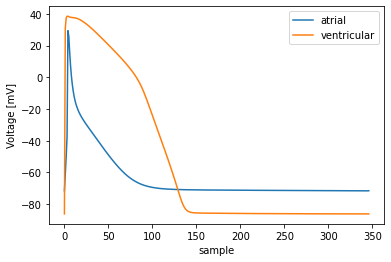

In [3]:
# look at the data dimensions
print(adata['Vatrial'].shape)
print(adata['Vventricular'].shape)

# let's see how the data looks like
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')

### Task 1. Pre-processing and manual feature extraction
In this first part we will be normalizing the data and extracting hand-crafted features that will be later
used for the classification task. Load the dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

* _(15 points) Data preparation and normalization._
Split the data between test and training sets by
randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented
in the training set (e.g., use the same number for both). Normalize the data so that each AP has zero resting potential and unit maximum amplitude. Create an array of corresponding labels for the data points. For ventricular type use the class label $+1$ and $-1$ for
atrial type.
Make two plots displaying your normalized training data for each of the classes. Use time units for the horizontal axis.

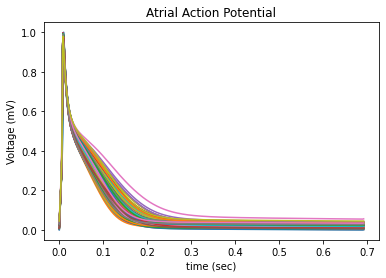

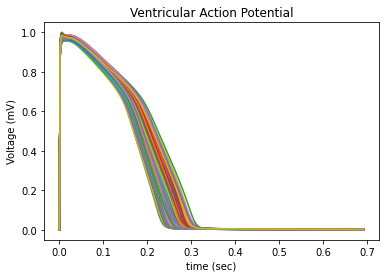

In [4]:
def normalize(x): 
  return (x - np.min(x)) / (np.max(x) - np.min(x))
# Extract atrial data
X_atrial = adata['Vatrial']
[D, N_atrial] = X_atrial.shape # D dimension of features (number of time points )

# Extract ventricular data
X_ventricular = adata['Vventricular']
N_ventricular = X_ventricular.shape[1]

ratioTrain = 0.1
f_s = 500

# ============================================================================
# Write your solution below
# ============================================================================
# ...

tf = .1
sample = np.random.uniform(size = N_atrial) < tf

atrialTrain = np.empty((D, round(tf * N_atrial))); # two empty 374 x 100 arrays
ventriTrain = np.empty((D, round(tf * N_atrial)));
atrialTest = np.empty((D, round(N_atrial * (1 - tf))))
ventriTest = np.empty((D, round(N_atrial * (1 - tf))))

currInd = 0; 
currInd2 = 0;
for i in range(len(sample)):
  if (sample[i]):
    atrialTrain[:, currInd] = X_atrial[:, i]
    ventriTrain[:, currInd] = X_ventricular[:, i]
    currInd = currInd + 1
    if (currInd >= 100):
      break
  if (~sample[i]):
    atrialTest[:, currInd] = X_atrial[:, i]
    ventriTest[:, currInd] = X_ventricular[:, i]
    currInd2 = currInd2 + 1
    if (currInd >= 900):
      break
atrialTrain = X_atrial[:, sample]
atrialTest = X_atrial[:, ~sample]
ventriTrain = X_ventricular[:, sample]
ventriTest = X_ventricular[:, ~sample]


atrialTrain = normalize(atrialTrain)
ventriTrain = normalize(ventriTrain)
atrialTest = normalize(atrialTest)
ventriTest = normalize(ventriTest)

atrialTrain_rows, atrialTrain_cols = atrialTrain.shape
atrialTrain_class = np.ones(atrialTrain_cols)
atrialTrain_class = - atrialTrain_class


ventriTrain_rows, ventriTrain_cols = ventriTrain.shape
ventriTrain_class = np.ones(ventriTrain_cols)

# set x-axis to time by scaling: divided current scale by frequency and 
# set step as 1/frequency
x = np.arange(0, len(atrialTrain) / f_s, step= 1/f_s); 

plt.figure(); 
plt.plot(x,atrialTrain);
plt.xlabel("time (sec)");
plt.ylabel("Voltage (mV)");
plt.title("Atrial Action Potential");

plt.figure();
plt.plot(x,ventriTrain);
plt.xlabel("time (sec)");
plt.ylabel("Voltage (mV)");
plt.title("Ventricular Action Potential");




* _(20 points) Hand-crafted features._
The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$ of its value. Write a function that computes APD at a given
percentage $x\in[0,1]$. Compute also the _Average of the Action Potential_ (AAP) and build two-dimensional features
by concatenating APD@$0.5$ and AAP. Make a scatter plot (APD vs AAP) of the training data using these two features. Use
different colors and/or markers to represent each class.


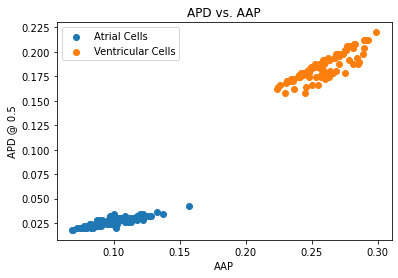

In [5]:
# ============================================================================
# compute hand-crafted features such as APA and APDx
# ============================================================================
import seaborn as sns

def apdx(X,alpha=0.5,fs=500):
    maxInd = np.argmax(X)
    maxPot = X[maxInd]
    alphaMaxPot = alpha * maxPot;
    absValArray = np.abs(X - alphaMaxPot);
    smallest_difference_index = absValArray.argmin()
    apd = smallest_difference_index - maxInd # in freq
    apd = apd / fs
    return apd

def aapx(X):
  return np.average(X)



# Generate APD@0.5 for each type of cell 
atrialTrainAPD = []
atrialTrainAAP = []
ventriTrainAPD = []
ventriTrainAAP = []
atrialTestAPD = []
atrialTestAAP = []
ventriTestAPD = []
ventriTestAAP = []
for i in range(atrialTrain_cols):
  tempAtrialData = atrialTrain[:, i] 
  tempVentriData = ventriTrain[:, i]
  atrialTrainAPD.append(apdx(tempAtrialData))
  ventriTrainAPD.append(apdx(tempVentriData))
  atrialTrainAAP.append(aapx(tempAtrialData))
  ventriTrainAAP.append(aapx(tempVentriData))

for i in range(len(atrialTest[0])):
  tempAtrialData = atrialTest[:, i]
  tempVentriData = ventriTest[:, i]
  atrialTestAPD.append(apdx(tempAtrialData))
  atrialTestAAP.append(apdx(tempVentriData))
  ventriTestAPD.append(aapx(tempAtrialData))
  ventriTestAAP.append(aapx(tempVentriData))

atrialTrainAPD = np.c_[atrialTrainAPD]
atrialTrainAAP = np.c_[atrialTrainAAP]
ventriTrainAPD = np.c_[ventriTrainAPD]
ventriTrainAAP = np.c_[ventriTrainAAP]

atrialTestAPD = np.c_[atrialTestAPD]
atrialTestAAP = np.c_[atrialTestAAP]
ventriTestAPD = np.c_[ventriTestAPD]
ventriTestAAP = np.c_[ventriTestAAP]


plt.figure()
plt.scatter(atrialTrainAAP, atrialTrainAPD)
plt.scatter(ventriTrainAAP, ventriTrainAPD,)
plt.legend(['Atrial Cells', 'Ventricular Cells'])
plt.ylabel("APD @ 0.5");
plt.xlabel("AAP");
plt.title("APD vs. AAP")



# Make 2D sets
aTrain = np.concatenate((atrialTrainAPD, atrialTrainAAP), axis = 1)
aTest = np.concatenate((atrialTestAPD, atrialTestAAP), axis = 1)
vTrain = np.concatenate((ventriTrainAPD, ventriTrainAAP), axis = 1)
vTest = np.concatenate((ventriTestAPD, ventriTestAAP), axis = 1)


### Task 2. Classification

* _(25 points) Nearest-neighbor classifier._
Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}

Compute and display the classification accuracy over the testing dataset using the handcrafted training features of **Task 1**.

In [6]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

#TODO CHANGE THIS
def nn_classify(Xtest,Xtrain,Ytrain):
  # Iterate through each column of Xtest
  yPred = [];
  for i in range(len(Xtest)):
    diff = [];
    for j in range(len(Xtrain)):
      diff.append((np.abs(Xtest[i][0]-Xtrain[j][0])**2) + np.abs((Xtest[i][1]-Xtrain[j][1])**2))
    k = np.argmin(diff)
    yPred.append(Ytrain[k])
  return yPred
    

    
    # implement your nearest-neighbor classifier below
    # ...

# Create full training data set 
trainData = np.concatenate((aTrain, vTrain),axis = 1)

trainData_rows, trainData_cols = trainData.shape
# concatenate the atrial and ventricular classification sets on axis 1
classifiers = np.concatenate((atrialTrain_class, ventriTrain_class))

testData = np.concatenate((aTest, vTest), axis = 1)
testClassAtrial = - np.ones(N_atrial - len(trainData))
testClassVentri = np.ones(N_atrial - len(trainData))
testClass = np.concatenate((testClassAtrial, testClassVentri))


predClass = nn_classify(testData, trainData, classifiers)


# calculate accuracy of predictions by comparing with testData classifications
accSum = 0;
for i in range(len(predClass)):
  if (predClass[i] == testClass[i]):
    accSum = accSum + 1
accuracy = (accSum / len(predClass)) * 100
print("Classification Accuracy over Testing Data: " + str(accuracy) + "%")



Classification Accuracy over Testing Data: 100.0%


* _(40 points) Two-layer Neural Network._
 Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $x \in \mathbb{R}^D$, $f_\theta: \mathbb{R}^p \to \mathbb{R}$ is a _linear prediction function_ (i.e., classification layer) with $p$ parameters. Furthermore we define $\theta = [\boldsymbol w^T, b]^T$ with $w \in \mathbb{R}^p$ and $b \in \mathbb{R}$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W_1 \boldsymbol x + \boldsymbol b_1\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 Where $\phi: \mathbb{R}^D \to \mathbb{R}^p$, $\boldsymbol W_1 \in \mathbb{R}^{p \times D}$, $b_1 \in \mathbb{R}^{p}$. In order to find the network's parameters $\Theta=\{\boldsymbol W_1, \boldsymbol b_1, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{w}\lVert \boldsymbol w\rVert^2 + \frac{1}{W}\lVert\boldsymbol W_1\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $w,W$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

    * Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Use $p \geq 2$ for best results.  Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.
    
    * Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully choose the stepsize and number of iterations until you see the method converges (i.e., the cost function gets to a "plateau").
    
    * Plot the cost over the iterations and display the classification accuracy over the testing dataset.

Accuracy from tensor model: 100.0%


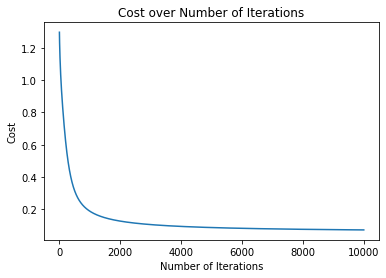

<Figure size 432x288 with 0 Axes>

In [9]:
torch.manual_seed(0) # fix random number generator
stepSize = 5e-3
numIterations = 10000
lambdaValue = 1
p = 2

# ============================================================================
# Write your solution below
# ============================================================================
# Define Xtrain as a Ntrain x D tensor and Ytrain should be a Ntrain x 1
# Need to concatenate atrialTrain and ventriTrain and then rotate 90 deg counterclockwise


Xtrain = np.concatenate((atrialTrain, ventriTrain), axis = 1)
Xtrain = Xtrain.T
#Xtrain = Xtrain - 0 # To deal with runtime error of torch
Xtrain = torch.from_numpy(Xtrain).float()

Ytrain = torch.from_numpy(classifiers).float().unsqueeze(1)


# Use torch.nn.Linear to define a linear function with D inputs and p outputs. Use bias=True
fun1 = torch.nn.Linear(D, p, bias= True)
# Define a Rectified Linear Unit using torch.nn.ReLU()
fun2 = torch.nn.ReLU()
# Use torch.nn.Linear to define another linear funcion with p inputs and 1 output. Use bias=True
fun3 = torch.nn.Linear(p, 1, bias= True)
network = torch.nn.Sequential(
    fun1,
    fun2,
    fun3
)
cost = []
#loss_fn = torch.nn.MSELoss(reduction='sum')
loss_fn = torch.nn.MSELoss()
for iteration in range(numIterations):
    # Use network to predict Y
    y_pred = network(Xtrain)
    # Define the cost function 
    costFn = loss_fn(y_pred, Ytrain) + lambdaValue * ((fun1.weight ** 2).mean() + (fun3.weight ** 2).mean())
    # Backpropagation: Update the gradients of the cost function using it's backward() method
    costFn.backward()
    # Updating parameters based on gradients
    with torch.no_grad():
        for parameter in network.parameters(): parameter -= stepSize*parameter.grad
        network.zero_grad()
    cost = np.append(cost, costFn.item())

plt.figure()
plt.plot(cost)
plt.xlabel("Number of Iterations");
plt.ylabel("Cost")
plt.title("Cost over Number of Iterations")

plt.figure();
Xtest = np.concatenate((atrialTest, ventriTest), axis = 1)
Xtest = Xtest.T
Xtest = torch.Tensor(Xtest)
#How are we doing in sample?
yTestPred = network(Xtest)
predClass = np.sign(yTestPred.detach())
yTestPred = yTestPred.tolist()
testClass = testClass

yTestPred = np.sign(yTestPred)
sum = 0; 
for i in range(len(testClass)):
  if (testClass[i] == yTestPred[i]):
    sum = sum + 1
accuracy = (sum / len(testClass)) * 100
print("Accuracy from tensor model: " + str(accuracy) + "%")
